# システム解析論 レポート 2

29C23002 石川健太郎

In [ ]:
funcprot(0); // disable message on redefining a function

In [ ]:
[s, s_info] = loadwave('SpeechOnTrafficnoise.wav');
Fₛ = s_info(3); // sampling rate
Mₛ = s_info(8); // number of samples

波形を確認して、騒音のみの区間を探す。

70,000 付近以降のサンプルが騒音のみの区間と読み取れる。

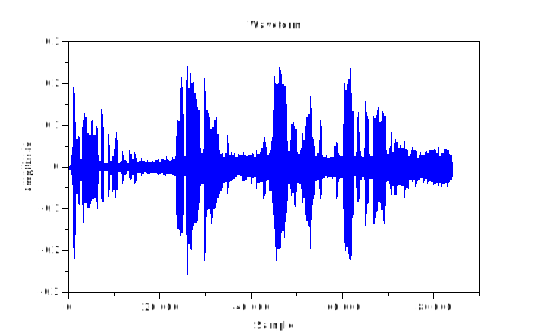

In [3]:
// thinning out points for vector file lightweighting
plot(1:5:Mₛ, s(1:5:$));
xtitle('Waveform', 'Sample', 'Amplitude');
gca().data_bounds = [1, -0.3; Mₛ, 0.3];

In [ ]:
N = 256; // FFT size
h = window('hn', N); // Hanning window
Nₛₕ = N / 2; // shift size of FFT
L = floor(Mₛ/Nₛₕ) - 1; // number of loop
P = 4;// last 4 frames are noise
// parameter for Wiener filter
β = 0.98;
// parameters for Lotter and Vary method
ν = 0.126;
μ = 1.74;

末尾 4 flame からノイズのパワーを計算する。

In [ ]:
σᵈ² = zeros(1, N); // power of noise
for l = 1:P
    // start point of FFT
    n = Mₛ - (l + 1) * Nₛₕ;
    // average of power spectrum of noise
    σᵈ² = σᵈ² + abs(fft(s(n+1:n+N).*h))^2 / P;
end

In [ ]:
y = [];
ξ = zeros(1,N); // SNR

yₗ₋₁_tail=zeros(1, Nₛₕ);
γₗ = zeros(1, N);
γₗ₋₁ = zeros(1, N);
G = ones (1,N);
for l = 1:L-P-1
    n = (l-1) * Nₛₕ;
    Xₗ = fft(s(n+1:n+N).*h);
    γₗ = (abs(Xₗ))^2 ./ σᵈ²;
    tᵧ = γₗ - 1;
    tᵧ(tᵧ <= 0) = 0; // tᵧ = max(γₗ - 1, 0)
    ξ = β * γₗ₋₁ .* G^2 + (1 - β) * tᵧ;
    // avoid division by zero
    γₗ(γₗ == 0) = 0.0001;
    ξ(ξ == 0) = 0.0001; 
    uₗ = sqrt( γₗ .* ξ );
    uₗ = 0.5 - 0.25 * μ * uₗ^(-1);
    G = uₗ + sqrt( uₗ .* uₗ + 0.5 * ν * γₗ^(-1));
    // limit G to [0, 1]
    G(G <= 0) = 0;
    G(G >= 1) = 1;
    yₗ = ifft(G.*Xₗ);
    y =[y, yₗ₋₁_tail + yₗ(1:Nₛₕ)];
    yₗ₋₁_tail = yₗ(Nₛₕ+1:N);
    γₗ₋₁ = γₗ;
end

ノイズを除去した波形は次の通り。

波形からもノイズが低減されていることが分かる。

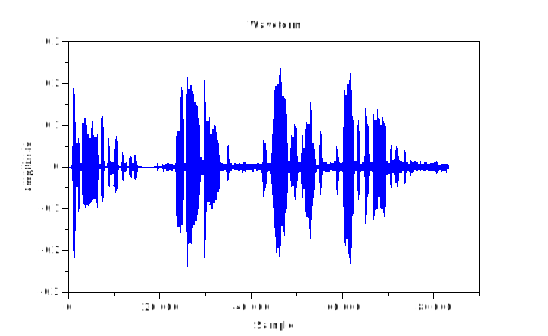

In [7]:
// thinning out points for vector file lightweighting
plot(1:5:length(y), y(1:5:$));
xtitle('Waveform', 'Sample', 'Amplitude');
gca().data_bounds = [1, -0.3; Mₛ, 0.3];

In [ ]:
wavwrite(y, Fₛ, 'output.wav');

## 添付ファイル

| ファイル名 | 内容 |
| --- | --- |
| output.wav | ノイズを除去した音声ファイル |

## Scilab 実行環境

In [ ]:
[version, opts] = getversion();
COMPILER = opts(1);
ARCH = opts(2);
RELEASE_MODE = opts($-2);
RELEASE_DATE = opts($-1);
RELEASE_TIME = opts($);
VER_NUMS = getversion('scilab');

In [10]:
mprintf("COMPILER    : %s", COMPILER);
mprintf("ARCH        : %s", ARCH);
mprintf("RELEASE_MODE: %s", RELEASE_MODE);
mprintf("RELEASE_DATE: %s", RELEASE_DATE);
mprintf("RELEASE_TIME: %s", RELEASE_TIME);
mprintf("VERSION     : %d.%d.%d", VER_NUMS(1), VER_NUMS(2), VER_NUMS(3));

COMPILER    : GCC
ARCH        : x64
RELEASE_MODE: release
RELEASE_DATE: Nov 21 2020
RELEASE_TIME: 10:42:41
VERSION     : 6.1.0
